In [1]:
from google.colab import drive
drive.mount('/content/drive')

FOLDERNAME = 'SPR/'
assert FOLDERNAME is not None, "[!] Enter the foldername."

import sys
sys.path.append('/content/drive/My Drive/{}'.format(FOLDERNAME))
%cd /content/drive/My\ Drive/$FOLDERNAME
!pip3 install -U libsvm-official

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/My Drive/SPR
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader
from torch.utils.data import sampler

import torchvision.datasets as dset
import torchvision.transforms as T

import numpy as np
from libsvm.svmutil import *
from utils import flatten, PCA_proj 

USE_GPU = False
dtype = torch.float32 # We will be using float throughout this tutorial.

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Constant to control how frequently we print train loss.
print_every = 100
print('using device:', device)

using device: cpu


In [3]:
# parameters
NUM_TRAIN = 10000
NUM_TEST = 10000
LEARNING_RATE = 1e-3
BATCH_SIZE = 32
N_EPOCHS = 10
N_CLASSES = 10

transform = T.Compose([T.Resize((28, 28)),
                        T.ToTensor()])

mnist_train = dset.MNIST('./Datasets', train=True, download=True,
                             transform=transform)
loader_train = DataLoader(mnist_train, batch_size=NUM_TRAIN)

mnist_test = dset.MNIST('./Datasets', train=False, download=True, 
                            transform=transform)
loader_test = DataLoader(mnist_test,  batch_size=NUM_TEST)

In [4]:
X_train = loader_train.dataset.data.cpu().detach().numpy()
y_train = loader_train.dataset.targets.cpu().detach().numpy()
X_test = loader_test.dataset.data.cpu().detach().numpy()
y_test = loader_test.dataset.targets.cpu().detach().numpy()

X_train = flatten(X_train)
X_test = flatten(X_test)
print(X_train.shape)

#PCA 
X_train_PCA, V_train = PCA_proj(X_train)
X_test_PCA = np.real(np.matmul(X_test, V_train))


(60000, 784)
---------------- Performing PCA on Data --------------------
60000 784
Covariance calculated
Required Dimension:  331
Got new clipped projection matrix
X_train projected


In [5]:
import matplotlib.pyplot as plt

def train(p, x, y):
    prob = svm_problem(y[:10000], x[:10000])
    m = svm_train(prob, p)
    return m

def predict(model, x,y):
    p_label, p_acc, p_val = svm_predict(y, x ,model)
    return p_acc


# ch = int(input('Enter the choice 1.PCA 2.MDA'))

# if ch == 1:
#     x_train_reduced, eig_vecs = PCA(X_train)
#     x_test_reduced = np.real(np.matmul(X_test, V_train))
# else:
#     x_train_reduced, t_matrix = MDA(X_train, y_train)
#     x_test_reduced = np.real((np.matmul(t_matrix.T, X_test.T)).T)
#     print('MDA done on train data')

def SVM(choice, X_train , y_train , X_test , y_test):
  accuracies = []
  if choice == 1:
      print("Doing linear SVM")
      param = svm_parameter('-q -t 0')
      model = train(param, X_train, y_train)
      predict(model, X_test, y_test)

  elif choice == 2:
      print("Doing Polynomial SVM")
      degree = [' -d 2' , ' -d 4', ' -d 6']
      for i in degree:
          param = svm_parameter('-q -t 1 -g 0.001 -r 1' + i)
          model = train(param, X_train, y_train)
          acc = predict(model, X_test, y_test)
          accuracies.append(acc[0])
      plt.plot(degree, accuracies)
      plt.show()
          
  else:
      print("Doing RBF SVM")
      gamma = [' -g 1000' , ' -g 10']
      for i in gamma:
          param = svm_parameter('-q -t 2' + i)
          model = train(param, X_train, y_train)
          acc = predict(model, X_test, y_test)
          accuracies.append(acc[0])
      print(accuracies)
      plt.plot(gamma, accuracies)
      plt.show()



In [6]:
SVM(1 , X_train_PCA , y_train , X_test_PCA , y_test)

Doing linear SVM
Accuracy = 66.21% (6621/10000) (classification)


Doing Polynomial SVM
Accuracy = 50.15% (5015/10000) (classification)
Accuracy = 30.92% (3092/10000) (classification)
Accuracy = 27.37% (2737/10000) (classification)


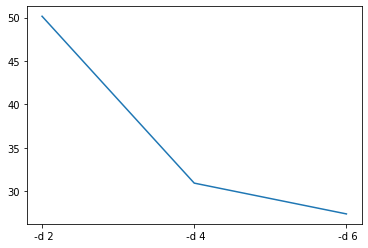

In [7]:
SVM(2 , X_train_PCA , y_train , X_test_PCA , y_test)

Doing RBF SVM
Accuracy = 11.35% (1135/10000) (classification)
Accuracy = 11.35% (1135/10000) (classification)
[11.35, 11.35]


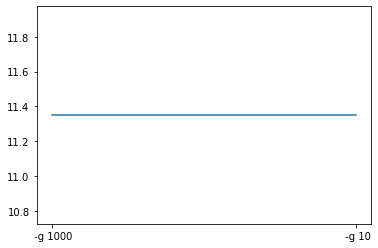

In [8]:
SVM(3, X_train_PCA , y_train , X_test_PCA , y_test)

In [10]:
from MDA import *
X_train_MDA, Theta = MDA(X_train, y_train,10)
X_test_MDA = np.real(np.matmul(X_test, Theta))


/usr/local/lib/python3.8/dist-packages/numpy/core/fromnumeric.py:86: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)


In [11]:
SVM(1 , X_train_MDA , y_train , X_test_MDA , y_test)

Doing linear SVM
Accuracy = 22.61% (2261/10000) (classification)


Doing Polynomial SVM
Accuracy = 11.35% (1135/10000) (classification)
Accuracy = 11.35% (1135/10000) (classification)
Accuracy = 11.35% (1135/10000) (classification)


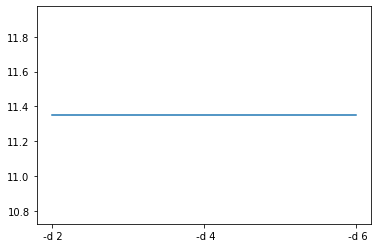

In [12]:
SVM(2 , X_train_MDA , y_train , X_test_MDA , y_test)

Doing RBF SVM
Accuracy = 89.99% (8999/10000) (classification)
Accuracy = 87.88% (8788/10000) (classification)
[89.99000000000001, 87.88]


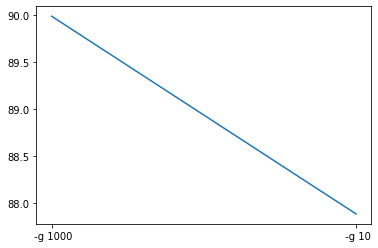

In [13]:
SVM(3 , X_train_MDA , y_train , X_test_MDA , y_test)